In [1]:
!pip install sliderule

In [2]:
# standard imports
import datetime
import pandas as pd

import os
import dask
from dask.diagnostics import ProgressBar
import geopandas as gpd
import ipyleaflet
import ipywidgets as widgets
import logging
import panel as pn
pn.extension()
import matplotlib.lines
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import shapely.geometry
import warnings
# grimp and nisar functions
# import grimpfunc as grimp
# import nisardev as nisar
# sliderule functions
import sliderule
import sliderule.icesat2
import sliderule.io
import sliderule.ipysliderule

import pickle

import glob

# some mapping widgets
import ipyleaflet
from ipyleaflet import Map, GeoData, Rectangle, basemaps, LayersControl, basemap_to_tiles, TileLayer, SplitMapControl, Polygon, MagnifyingGlass
import ipywidgets

# database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas

# import this to use define sql functions (e.g. postgis!)
from sqlalchemy.sql import func 

# Import this to convert to a rasterio object for easy plotting
from snowexsql.conversions import raster_to_rasterio 

# Import a convenient function to plot with 
import rasterio
from rasterio.plot import show

# register progress bar and set workers
ProgressBar().register()
dask.config.set(num_workers=2)
# turn off warnings for demo
warnings.filterwarnings('ignore')

## Pickle import boundary of Grand Mesa

In [3]:
# Polygon of Grand Mesa boundary
out_fp = "../../data/bounds.pkl"
polygon = pickle.load(open(out_fp, 'rb'))

poly_gdf = gpd.GeoDataFrame(polygon['Grand Mesa, CO'], index = [0], columns = ['geometry'], crs='epsg:4326')

## Rasterio import ASO DEM tif file

In [5]:
file = "../../data/ASO_3M_PCDTM_USCOGM_20160926_20160926.tif"

In [39]:
# resample 3 x 3 m image into 20 x 20 image
# !gdal_translate  -tr 20, 20 ./ASO_3M_PCDTM_USCOGM_20160926_20160926.tif ./ASO_3M_PCDTM_USCOGM_20160926_20160926_resample.tif

Input file size is 12450, 6500
0...10...20...30...40...50...60...70...80...90...100 - done.


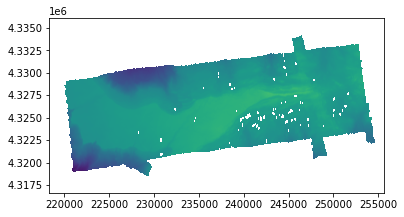

<AxesSubplot:>

In [6]:
src = rasterio.open(file)
array = src.read(1)
trsform = src.transform
lon, lat = trsform * (0,0)
show(src, vmin = 2000, vmax = 4000)

## Sliderule: Import ICESAt-2 data for this region

In [7]:
# set the url for the sliderule service
# set the logging level
sliderule.icesat2.init("icesat2sliderule.org", loglevel=logging.WARNING)

In [8]:
# display widgets for setting SlideRule parameters
SRwidgets = sliderule.ipysliderule.widgets()
# show widgets
widgets.VBox([
    SRwidgets.asset,
    SRwidgets.release,
    SRwidgets.surface_type,
    SRwidgets.length,
    SRwidgets.step,
    SRwidgets.confidence,
    SRwidgets.land_class,
    SRwidgets.iteration,
    SRwidgets.spread,
    SRwidgets.count,
    SRwidgets.window,
    SRwidgets.sigma,
])

In [9]:
widgets.VBox([SRwidgets.projection, SRwidgets.layers])

In [15]:
# create ipyleaflet map in specified projection
m = sliderule.ipysliderule.leaflet(SRwidgets.projection.value)
m.map

# sliderule asset and data release
asset = SRwidgets.asset.value
release = SRwidgets.release.value

# build sliderule parameters using latest values from widget
params = {
    # surface type: 0-land, 1-ocean, 2-sea ice, 3-land ice, 4-inland water
    "srt": SRwidgets.surface_type.index,
    # length of ATL06-SR segment in meters
    "len": SRwidgets.length.value,
    # step distance for successive ATL06-SR segments in meters
    "res": SRwidgets.step.value,
    # confidence level for PE selection
    "cnf": SRwidgets.confidence.value,
    # ATL08 land surface classifications
    "atl08_class": list(SRwidgets.land_class.value),
    # maximum iterations, not including initial least-squares-fit selection
    "maxi": SRwidgets.iteration.value,
    # minimum along track spread
    "ats": SRwidgets.spread.value,
    # minimum PE count
    "cnt": SRwidgets.count.value,
    # minimum height of PE window in meters
    "H_min_win": SRwidgets.window.value,
    # maximum robust dispersion in meters
    "sigma_r_max": SRwidgets.sigma.value
}

# Region of interest
region = sliderule.icesat2.toregion(poly_gdf)

params["t0"] = '2019-12-01T00:00:00Z' # Start date
params["t1"] = '2020-03-31T00:00:00Z' # End date

# create an empty geodataframe
gdf = sliderule.icesat2.__emptyframe()
# for each region of interest

params["poly"] = region["poly"]   # will always be the convex hull of the polygon
params["raster"] = region["raster"]   # raster will include all vertices, including holes. This is more processing, but is only an issue with very large requests.
gdf = sliderule.icesat2.atl06p(params, asset, version=release)

gdf = gdf.reset_index()
gdf = gdf.rename(columns ={'index':'time'})

print("ATL08 data is loaded!")


ATL08 data is loaded!


In [16]:
# Process gdf file: add temporal and spatial information
for i in range(0, len(gdf)):
    # gdf.loc[i, "date"] = gdf["time"][i].date()
    gdf.loc[i, "year"] = gdf["time"][i].year
    gdf.loc[i, "month"] = gdf["time"][i].month
    gdf.loc[i, "day"] = gdf["time"][i].day
    gdf.loc[i, "lat"] = gdf["geometry"][i].y
    gdf.loc[i, "lon"] = gdf["geometry"][i].x

## Calculate snow depth combining ATL08 & ASO DEM

In [17]:
# Sample ASO DEM with ATL08 geodataframe
def sample_raster(df, src, diff_col=None):
    #df_proj = df.to_crs(src.crs)
    coord = [(pt.x, pt.y) for pt in df.to_crs(src.crs).geometry]
    s = np.fromiter(src.sample(coord), dtype=src.dtypes[0])
    #s[s == src.nodata] = np.nan
    sm = np.ma.masked_equal(s, src.nodata)
    sm[sm <= 0] = np.nan
    sample_colname = os.path.splitext(os.path.split(src.name)[-1])[0]
    df[sample_colname] = sm
    if diff_col is not None:
        out_colname = 'diff'
        df[out_colname] = df[diff_col] - df[sample_colname]
        return df
    else:
        out_colname = sample_colname
        return out_colname

In [18]:
gdf2 = sample_raster(gdf, src, "h_mean")

# Remove invalid data points
gdf2 = gdf2[gdf2["diff"] >= -9999].reset_index(drop = True)

In [19]:
gdf2

,time,cycle,dh_fit_dy,h_mean,pflags,h_sigma,rgt,dh_fit_dx,segment_id,gt,...,delta_time,rms_misfit,geometry,year,month,day,lat,lon,ASO_3M_PCDTM_USCOGM_20160926_20160926,diff
0,2019-12-11 14:40:40.559739792,5,0.0,3078.088775,0,0.083455,1156,0.104785,784793,30,...,6.131044e+07,0.318838,POINT (-107.93418 39.10518),2019.0,12.0,11.0,39.105178,-107.934178,3077.856934,0.231841
1,2019-12-11 14:40:40.562557320,5,0.0,3080.824590,0,0.087478,1156,0.145182,784794,30,...,6.131044e+07,0.397028,POINT (-107.93420 39.10500),2019.0,12.0,11.0,39.104998,-107.934200,3080.519043,0.305547
2,2019-12-11 14:40:40.565375024,5,0.0,3083.739153,0,0.095344,1156,0.150389,784795,30,...,6.131044e+07,0.345443,POINT (-107.93422 39.10482),2019.0,12.0,11.0,39.104818,-107.934222,3083.927002,-0.187849
3,2019-12-11 14:40:40.568192888,5,0.0,3087.406782,0,0.100775,1156,0.226380,784796,30,...,6.131044e+07,0.417440,POINT (-107.93425 39.10464),2019.0,12.0,11.0,39.104638,-107.934245,3087.802979,-0.396196
4,2019-12-11 14:40:40.576644928,5,0.0,3097.669233,0,0.188878,1156,0.164025,784799,30,...,6.131044e+07,0.507957,POINT (-107.93431 39.10410),2019.0,12.0,11.0,39.104099,-107.934313,3099.016113,-1.346880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4329,2020-03-11 10:20:31.301843744,6,0.0,2513.829993,0,0.080324,1156,-0.034596,785569,40,...,6.915723e+07,0.481021,POINT (-108.14532 38.98028),2020.0,3.0,11.0,38.980275,-108.145319,2519.097900,-5.267907
4330,2020-03-11 10:20:31.304657312,6,0.0,2515.797338,0,0.110074,1156,0.185592,785570,40,...,6.915723e+07,0.901618,POINT (-108.14534 38.98010),2020.0,3.0,11.0,38.980096,-108.145341,2516.666504,-0.869166
4331,2020-03-11 10:20:31.307465624,6,0.0,2521.014406,0,0.056537,1156,0.315297,785571,40,...,6.915723e+07,0.417994,POINT (-108.14536 38.97992),2020.0,3.0,11.0,38.979916,-108.145362,2518.617676,2.396730
4332,2020-03-11 10:20:31.310269488,6,0.0,2526.408691,0,0.073788,1156,0.217654,785572,40,...,6.915723e+07,0.607248,POINT (-108.14538 38.97974),2020.0,3.0,11.0,38.979736,-108.145384,2518.334961,8.073730


## Visualize snow depth (elevation difference)

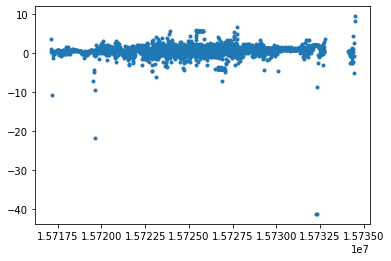

In [26]:
# Draw profile of elevation difference (snow depth)
idx = (gdf2["day"] == gdf2["day"].unique()[0])
plt.plot(gdf2["distance"][idx], gdf2['diff'][idx], '.')

In [27]:
# Draw map of elevation differences
m.GeoData(gdf2, column_name="diff", cmap=SRwidgets.colormap,
    max_plot_points=10000, tooltip=True, colorbar=True)

m.map

Map(bottom=50293.0, center=[39, -108], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_tit…